In [1]:
# importing the required libraries

import numpy as np
import random
import matplotlib.pyplot as plt
import time
from typing import Tuple, Optional, Dict

# initializing the seed to 42
np.random.seed(seed=42)
random.seed(a=42)

In [2]:
# Defining the function to calculate chromosome fitness

def fitcal(genotype: np.ndarray) -> float:
    is_feasible = (genotype*weights).sum() <= capacity
    if is_feasible:
        return (genotype*weights).sum()
    else:
        return 0.0

In [3]:
# Defining a function for doing chromosome cross-over

def do_x_over(father: np.ndarray, mother: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    cross_point = np.random.randint(len(father)+1)
    son1 = np.append(father[:cross_point], mother[cross_point:])
    son2 = np.append(mother[:cross_point], father[cross_point:])

    return son1, son2, cross_point

In [4]:
# Defining the function for performing the rouelette wheel chromosome selection

def select(population: np.ndarray, fitness: np.ndarray, taboo:Optional[int]=None) -> int: 
    f_copy = np.copy(fitness)
    f_copy = np.clip(f_copy, 0, None)
    if taboo is not None:
        f_copy[taboo] = 0
    r = np.random.uniform(0, f_copy.sum())    
    for x in range(len(fitness)):
        if f_copy[:x+1].sum() > r:
            return x
    # Pick a random individual
    return random.sample([i_ for i_ in range(len(population)) if taboo == None or not i_ == taboo], 1)[0]

In [5]:
# Defining a function for replacing a certain chromosome by a new input chromosome

def replace_chromosome(x:int, new_ind: np.ndarray, population: np.ndarray, age: np.ndarray, fitness: np.ndarray):
    population[x] = new_ind
    age[x] = 0
    fitness[x] = fitcal(population[x])

In [6]:
# Defining a function to do drop mutation of a chromosome

# This function will essentially drop an item, that is flip the gene from '1' to '0'

def drop_mutation(genotype: np.ndarray) -> np.ndarray:
    while fitcal(genotype) <= 0.0001 and genotype.sum() > 0:        
        x_ = random.sample(list(np.argwhere(genotype == 1)), 1)[0]
        genotype[x_] = 0
    return genotype

In [7]:
# Defining a function to do pop mutation of a chromosome

# This function will essentially add an item, that is flip the gene from '0' to '1'

def pop_mutation(genotype: np.ndarray) -> np.ndarray:
    def small_enough_items(genotype) -> list():
        """ Gets the items that are small enough to be added to a solution """
        residual_cap = capacity - (genotype*weights).sum()
        return np.argwhere((weights < residual_cap) & (genotype == 0))
    smallies = small_enough_items(genotype)
    while len(smallies) > 0:        
        x_ = random.sample(list(smallies), 1)[0]
        genotype[x_] = 1
        smallies = small_enough_items(genotype)
    return genotype 
    if genotype.sum() < len(genotype):
        genotype[random.sample(list(np.argwhere(genotype == 0)), 1)[0]] = 1
    return genotype

In [8]:
# Defining a function to do switch mutation of a chromosome

# This function will essentially add an item an item that wasn't selected earlier or drop an item if it was, 
# i.e. flip the gene from '0' to '1' or '1' to '0' (just reverse the bit)

def switch_mutation(genotype: np.ndarray, likelihood: np.ndarray= None) -> np.ndarray:
    if genotype.sum() > 0 and genotype.sum() < len(genotype):
        items_in = list(np.argwhere(genotype == 1))
        items_out = list(np.argwhere(genotype == 0))
                             
        if likelihood is None:
            from_x = random.sample(items_in, 1)[0]
            to_x = random.sample(items_out, 1)[0]
        else:
            # Higher probability to remove items with less likelihood
            from_x = select(items_in, np.take(1/likelihood, items_in))
            # Higher probability to insert items with more likelihood
            to_x = select(items_out, np.take(likelihood, items_out))
        
        to_gene = genotype[to_x]
        genotype[to_x] = genotype[from_x]
        genotype[from_x] = to_gene

    return genotype

In [9]:
# Defining a function to print the intermediate populations with each passing generation

def print_population_generation(generation, population, fitness):
    print(f"--- Population at the Generation {str(generation)} --- ")
    for i_ in range(len(population)):
        print(f"{i_}: {population[i_]} => {fitness[i_]}")

In [10]:
# Defining the main function that implements the Genetic Algorithm using the different functions defined earlier

def Genetic_Algorithm_Call(population_0: np.ndarray, n_iterations: int, 
       mutation_p: float, mates_p: float,       
       do_pop_mutation: bool,
       pop_max_age: int,
       do_drop_mutation: bool,
       do_switch_mutation: bool,
       do_weighted_switch_mutation: bool,
       print_evolution: bool) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    # Initializing some parameters  
    population = np.copy(population_0)
    n_individuals = len(population)
    age = np.zeros(n_individuals) 
    best_of_generation = np.zeros(n_iterations)
    average_of_generation = np.zeros(n_iterations)
    chosen_one_at_gen = np.zeros(n_iterations)
    
    # Calculating the fitness array for the population
    fitness = np.asarray([fitcal(x) for x in population])
    chosen_one = None
    for i in range(n_iterations):
        # Printing the intermediate generations if required
        if print_evolution:
            print_population_generation(i, population, fitness)
        # Updating the poitner to the most optimal chromosome
        if chosen_one is None or fitness.max() > fitcal(chosen_one):
            chosen_one = np.copy(population[np.argmax(fitness)])
            
        # Appending the solutions with each passing generation
        best_of_generation[i] = fitness.max()
        average_of_generation[i] = fitness.mean()
        chosen_one_at_gen[i] = fitcal(chosen_one)

        age = age + 1 
        for mate in range(int(n_individuals*mates_p) + 1):
            if fitness.sum() > 0.00001:
                # Selecting the parent chromosomes for reproduction
                father_x = select(population, fitness)
                mother_x = select(population, fitness, father_x)
                son1, son2, cross_point = do_x_over(population[father_x], population[mother_x])

                # Selecting the two oldest chromosomes to discard them
                older1_x = select(population, age)
                older2_x = select(population, age, older1_x)
                
                # Replacing the elders with the new-borns
                replace_chromosome(older1_x, son1, population, age, fitness)
                replace_chromosome(older2_x, son2, population, age, fitness)
                if print_evolution:
                    print(f"Crossing: {father_x} + {mother_x} ({cross_point}) => {son1}, {son2} in {older1_x},{older2_x} ")
        
        # The following part is responsible for the different Mutations on the chromosomes
        if do_weighted_switch_mutation:
            likelihood = values/weights
        
        for g in range(n_individuals):
            
            # Doing a switch mutation on "sane" or acceptable individuals
            if do_switch_mutation:
                if(np.random.uniform() < mutation_p): 
                    if print_evolution:
                        before = np.copy(population[g])
                        
                    if do_weighted_switch_mutation:
                        population[g] = switch_mutation(population[g], likelihood)
                    else:
                        population[g] = switch_mutation(population[g])
                        
                    fitness[g] = fitcal(population[g])
                    if print_evolution:
                        print(f"Switch-mutation of {g}: {before} => {population[g]}")
                        
            # Doing a Pop Mutation for newborns
            if do_pop_mutation:
                if age[g] <= pop_max_age:
                    if print_evolution:
                        before = np.copy(population[g])
                    population[g] = pop_mutation(population[g])
                    fitness[g] = fitcal(population[g])
                    if print_evolution:
                        print(f"Pop-mutation of {g}: {before} => {population[g]}")
            
            # Performing a Drop Mutation on infeasible individuals
            if do_drop_mutation:
                if fitness[g] <= 0.00001:
                    if print_evolution:
                        before = np.copy(population[g])
                    population[g] = drop_mutation(population[g])
                    fitness[g] = fitcal(population[g])
                    if print_evolution:
                        print(f"Drop-mutation of {g}: {before} => {population[g]}")
                
    return best_of_generation, average_of_generation, chosen_one_at_gen, population, chosen_one

In [11]:
# Defining a function to run the genetic algorithm and also print the results obtained over the iterations performed

def generate_plot(population_0: np.ndarray, n_iterations: int, 
                 mutation_p: float, mates_p: float,
                 do_pop_mutation: bool,
                 pop_max_age: int,
                 do_drop_mutation: bool,
                 do_switch_mutation: bool,
                 do_weighted_switch_mutation: bool,
                 subplot_rows= 1, subplot_cols=1, subplot_index=1):

    x_axes = tuple([i for i in range(n_iterations)])
    print_evolution = False
    
    # Running the Genetic Algorithm on the input dataset
    best_of_generation, average_of_generation, chosen_one_at_gen,_, _chosen = Genetic_Algorithm_Call(population_0, n_iterations,
                                                                         mutation_p, mates_p,
                                                                         do_pop_mutation,
                                                                         pop_max_age,
                                                                         do_drop_mutation,
                                                                         do_switch_mutation,
                                                                         do_weighted_switch_mutation,
                                                                         False)
    # Updating the solution
    solution = chosen_one_at_gen[n_iterations-1]
    
    # Setting up the plotting grid
    plt.subplot(subplot_rows, subplot_cols, subplot_index)
    plt.plot(x_axes, tuple(best_of_generation))
    plt.plot(x_axes, tuple(chosen_one_at_gen))
    plt.plot(x_axes, tuple(average_of_generation))
    
    # Setting the title of the result graph to show the desired outputs
    plt.title(f"its:{n_iterations}, mut_p:{mutation_p}, inds:{len(population_0)}, mates:{mates_p} " 
              + f"=> {solution} : gap: {0 if opt is None else (opt - solution)*100/opt:.2f}%,"
              + f"Pop:{str(do_pop_mutation)}: {pop_max_age}, "
              + f"Drop:{str(do_drop_mutation)}, "
              + f"Switch:{str(do_switch_mutation)}/{str(do_weighted_switch_mutation)}")
    print("Optimal Value obtained by GA(Best): ",best_of_generation[-1])
    print("Optimal Value obtained by GA(Chosen): ",chosen_one_at_gen[-1])
    print("Optimal Value obtained by GA(Average): ",average_of_generation[-1])
    
    print("\nChosen One: ",_chosen)

In [12]:
# Defining a function to read and parse the input data

def data_load(instance_dir, instance) -> Tuple[float, np.ndarray, np.ndarray,
                                                   float, int, Dict[int, Tuple[float, float]]]:
    """
    Loads and parses the dataset
    """
    items = np.genfromtxt(instance_dir + instance + "_items.csv", delimiter=',',skip_header=1)
    info = np.genfromtxt(instance_dir + instance + "_info.csv", delimiter=',')

    # Capacity of the knapsack
    capacity = info[1, 1]

    # Value associated to each item
    values = items.astype(int)[:, 1]

    # Weight of each item
    weights = items.astype(int)[:, 2]
    
    # Expected Solution
    expected_sol = items.astype(int)[:, 3]

    # Number of items that can be selected = number of genes in a individual
    n_genes = len(values)

    # Optimal solution value
    opt = info[2, 1]
        
    items = {}
    for i in range(n_genes):
        items[i] = (weights[i], values[i])
    return capacity, values, weights, opt, n_genes, items, expected_sol

In [13]:
# Reading and parsing the input dataset

capacity, values, weights, opt, n_genes, items, expected_sol = data_load('./prof/','knapPI_1_7_1000_1')

In [14]:
# Checking the capacity of the knapsack

capacity

170.0

In [15]:
# Visualizing the values as obtained from the dataset

values

array([442, 525, 511, 593, 546, 564, 617])

In [16]:
# Visualizing the weights as obtained from the dataset

weights

array([41, 50, 49, 59, 55, 57, 60])

In [17]:
# Visualizing the expected optimal value

opt

169.0

In [18]:
# Visualizing the various items and their weight-value pairs

items

{0: (41, 442),
 1: (50, 525),
 2: (49, 511),
 3: (59, 593),
 4: (55, 546),
 5: (57, 564),
 6: (60, 617)}

In [19]:
# Modifying the plot area to a bigger size

plt.rcParams['figure.figsize'] = [20,10]

In [20]:
# Generating an initial random population

population_0 = np.random.randint(2, size=[20, n_genes])

In [21]:
# Visualizing the generated initial population

population_0

array([[0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 0, 1],
       [0, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

Optimal Value obtained by GA(Best):  169.0
Optimal Value obtained by GA(Chosen):  169.0
Optimal Value obtained by GA(Average):  164.9

Chosen One:  [0 1 0 1 0 0 1]


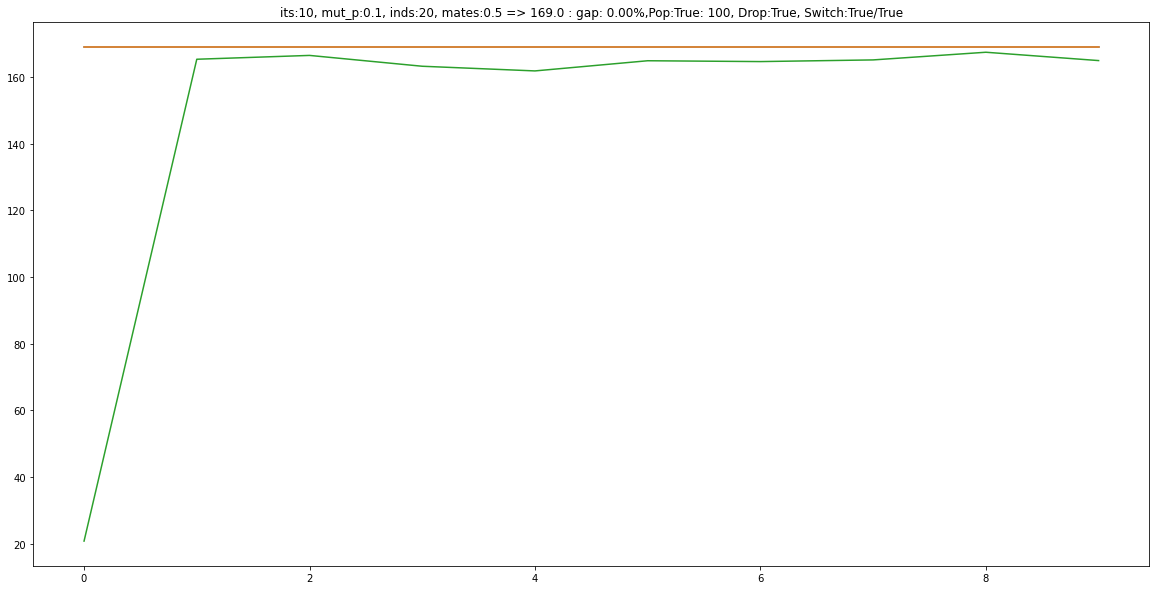

In [22]:
# Running the Genetic Algorithm on the input data and plotting the results over the iterations performed

generate_plot(population_0, n_iterations=10, mutation_p=0.1, mates_p=0.5, 
             do_pop_mutation=True, pop_max_age=100, do_drop_mutation=True, 
             do_switch_mutation=True,
             do_weighted_switch_mutation=True)
plt.show()

In [23]:
# Running only the Genetic Algorithm to visualize the intermediate steps without visualing the results in a plot 

best_of_generation, average_of_generation, chosen_one_at_gen, population, chosen_sol = Genetic_Algorithm_Call(
        population_0, n_iterations=10, mutation_p=0.1, mates_p=0.5, 
        do_pop_mutation=True, pop_max_age=30, do_drop_mutation=True, 
        do_switch_mutation=True,
        do_weighted_switch_mutation=True,
        print_evolution=True)

--- Population at the Generation 0 --- 
0: [0 1 0 0 0 1 0] => 107.0
1: [0 0 1 0 0 0 0] => 49.0
2: [1 0 1 1 1 0 1] => 0.0
3: [0 1 1 1 1 1 1] => 0.0
4: [1 1 0 0 1 1 1] => 0.0
5: [0 1 0 0 0 0 0] => 50.0
6: [1 1 1 1 1 0 1] => 0.0
7: [1 0 1 0 1 0 1] => 0.0
8: [1 0 0 0 0 0 0] => 41.0
9: [0 0 1 1 0 1 1] => 0.0
10: [1 1 0 1 0 1 1] => 0.0
11: [1 0 1 0 1 0 1] => 0.0
12: [0 0 1 0 1 1 1] => 0.0
13: [1 1 1 1 1 1 1] => 0.0
14: [1 0 0 1 1 1 1] => 0.0
15: [1 1 1 1 0 1 0] => 0.0
16: [1 1 0 1 0 1 1] => 0.0
17: [0 1 0 1 0 0 1] => 169.0
18: [1 0 1 1 1 0 0] => 0.0
19: [0 0 0 0 0 0 0] => 0.0
Crossing: 17 + 1 (5) => [0 1 0 1 0 0 0], [0 0 1 0 0 0 1] in 4,3 
Crossing: 1 + 17 (0) => [0 1 0 1 0 0 1], [0 0 1 0 0 0 0] in 17,10 
Crossing: 5 + 3 (0) => [0 0 1 0 0 0 1], [0 1 0 0 0 0 0] in 14,5 
Crossing: 17 + 5 (2) => [0 1 0 0 0 0 0], [0 1 0 1 0 0 1] in 8,11 
Crossing: 17 + 4 (1) => [0 1 0 1 0 0 0], [0 1 0 1 0 0 1] in 9,19 
Crossing: 11 + 0 (2) => [0 1 0 0 0 1 0], [0 1 0 1 0 0 1] in 1,2 
Crossing: 9 + 4 (7) => [0 1 0

In [24]:
# Printing the most optimal value provided by the Genetic Algorithm

chosen_one_at_gen[-1]

169.0

In [25]:
# Visualizing the optimal value expected (obtained as an input)

opt

169.0

In [26]:
# Printing the solution provided by the Genetic Algorithm

chosen_sol

array([0, 1, 0, 1, 0, 0, 1])

In [27]:
# Printing the expected optimal solution (obtained as an input)

expected_sol

array([0, 1, 0, 1, 0, 0, 1])